In [1]:
!pip install yfinance
! wget http://setup.johnsnowlabs.com/colab.sh -O - | bash

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 452.9/452.9 KB 8.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 213.0/213.0 KB 17.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 182.4/182.4 KB 18.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.0/132.0 KB 14.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 140.6/140.6 KB 16.1 MB/s eta 0:00:00
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled urllib3-1.24.3
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.8/5.8 MB 38.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 38.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
from sklearn.utils import shuffle
import string
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
nltk.download
nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('omw-1.4')
from nltk.tokenize import TweetTokenizer
import preprocessor as p

from datasets import Dataset, load_metric
from sklearn.model_selection import train_test_split
from transformers import DataCollatorWithPadding
from torch.utils.data import DataLoader
import torch
from transformers import TFDistilBertForSequenceClassification, TFAutoModelForSequenceClassification
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from transformers import AdamW
from transformers import get_scheduler
from tqdm.auto import tqdm
import yfinance as yf

# import flair

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


# twitter api v2 & mlflow model inference

In [5]:
!pip install snscrape

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.1/59.1 KB 6.0 MB/s eta 0:00:00


In [ ]:
# !snscrape --jsonl twitter-tweet 1579529287828324352
### {"_type": "snscrape.modules.twitter.Tweet", "url": "https://twitter.com/mstea_ebooks/status/1579529287828324352", "date": "2022-10-10T17:48:23+00:00", "content": "As pointed out in #archiveteam, now I can't say the word \"bot\" without like five bots instantly favouriting it", "renderedContent": "As pointed out in #archiveteam, now I can't say the word \"bot\" without like five bots instantly favouriting it", "id": 1579529287828324352, "user": {"_type": "snscrape.modules.twitter.User", "username": "mstea_ebooks", "id": 1663565360, "displayname": "o\u01ddW \u01ddp \u028e\u0287s\u0131W", "description": "If you heart a tweet by someone at the centre of a twitter fight, you should try to fix that", "rawDescription": "If you heart a tweet by someone at the centre of a twitter fight, you should try to fix that", "descriptionUrls": null, "verified": null, "created": "2013-08-11T22:06:44+00:00", "followersCount": 2288, "friendsCount": 3623, "statusesCount": 106395, "favouritesCount": 1, "listedCount": 27, "mediaCount": 0, "location": "", "protected": null, "linkUrl": null, "linkTcourl": null, "profileImageUrl": "https://pbs.twimg.com/profile_images/378800000321718465/e7533d3d49871b32c0f151d865bae096_normal.png", "profileBannerUrl": null, "label": null, "url": "https://twitter.com/mstea_ebooks"}, "replyCount": 0, "retweetCount": 0, "likeCount": 1, "quoteCount": 0, "conversationId": 1579529287828324352, "lang": "en", "source": "<a href=\"http://none.yet\" rel=\"nofollow\">mstea_ebooks</a>", "sourceUrl": "http://none.yet", "sourceLabel": "mstea_ebooks", "outlinks": null, "tcooutlinks": null, "media": null, "retweetedTweet": null, "quotedTweet": null, "inReplyToTweetId": null, "inReplyToUser": null, "mentionedUsers": null, "coordinates": null, "place": null, "hashtags": ["archiveteam"], "cashtags": null}

In [180]:
import snscrape.modules.twitter as sntwitter

search = 'Bed Bath and Beyond'
ticker = 'BBBY'
start = '2022-12-20'
end = '2022-12-30'

# Creating list to append tweet data to
tweets_list = []

# Using TwitterSearchScraper to scrape data and append tweets to list
for i,tweet in enumerate(sntwitter.TwitterSearchScraper(f'{search} lang:en exclude:retweets since:{start} until:{(pd.to_datetime(end) + pd.DateOffset(days=1)).strftime("%Y-%m-%d")}').get_items()):
    # if i>100:
    #     break
    tweets_list.append([tweet.date, tweet.id, tweet.content, tweet.user.username])
    
# Creating a dataframe from the tweets list above
tweets_df = pd.DataFrame(tweets_list, columns=['Datetime', 'Tweet Id', 'Text', 'Username'])

In [181]:
tweets_df.head() # 6720

,Datetime,Tweet Id,Text,Username
0,2022-12-30 23:31:25+00:00,1608969031884894208,@John_Hempton @Tiswattis1 @TyForReal5 @ryancoh...,DEmceekay
1,2022-12-30 23:30:14+00:00,1608968734424829958,@pridewasariot_ Love that bed bath and beyond ...,PugetSoundSRA
2,2022-12-30 22:51:44+00:00,1608959047281299457,"Bed, Bath and Beyond sales and profits are rep...",dazzzmaan
3,2022-12-30 22:37:07+00:00,1608955367454826496,At Bed Bath &amp; Beyond we also recognize th...,BedBathCareers
4,2022-12-30 22:10:42+00:00,1608948720313470977,how does bed bath and beyond have no planners ?,dontcallmesov


In [ ]:
spark.sparkContext.getConf().get('spark.jars.packages')

In [ ]:
import mlflow
import sparknlp
from sparknlp.base import *
from sparknlp.annotator import *
from pyspark.ml import Pipeline
import pandas as pd
from sparknlp.training import CoNLL
import pyspark
from pyspark.sql import SparkSession
import pyspark.sql.types as T
import pyspark.sql.functions as f
import json
import os

In [ ]:
input = tweets_df['Text']
try:
  input = dbutils.widgets.get("text")
  print('"text" input found: ' + input)
except:
  print('Unable to run: dbutils.widgets.get("text"). Setting it to NOT_SET')
  input = "NOT_SET"

df = spark.createDataFrame([[input]]).toDF('text')

logged_model = 'runs:/a8cf070528564792bbf66d82211db0a0/sentiment_analysis'
loaded_model = mlflow.pyfunc.load_model(model_uri=logged_model)
# Predict on a Spark DataFrame.
res_spark = loaded_model.predict(df.rdd)
annotationType = T.StructType([
            T.StructField('annotatorType', T.StringType(), False),
            T.StructField('begin', T.IntegerType(), False),
            T.StructField('end', T.IntegerType(), False),
            T.StructField('result', T.FloatType(), False),
            T.StructField('metadata', T.MapType(T.StringType(), T.StringType()), False),
            T.StructField('embeddings', T.ArrayType(T.FloatType()), False)
        ])
		
spark_res = spark.createDataFrame(res_spark[0], schema=annotationType)

_sentiment = spark_res.select("result").collect()
sentiment = [x['result'] for x in _sentiment]   # Our predictions

dbutils.notebook.exit(json.dumps({
  "status": "OK",
  "results": sentiment
}))

In [ ]:

def score_model(dataset: pd.DataFrame):
  url = 'https://DATABRICKS_URL/model/sentiment_analysis/Production/invocations'
  headers = {'Authorization': f'Bearer {os.environ.get("DATABRICKS_TOKEN")}'}
  data_json = dataset.to_dict(orient='split')
  response = requests.request(method='POST', headers=headers, url=url, json=data_json)
  if response.status_code != 200:
    raise Exception(f'Request failed with status {response.status_code}, {response.text}')
  return response.json()

In [184]:
hundred_test = tweets_df['Text'].values.tolist()[:5]
print(hundred_test)
print(sentiment[:5])

['Also, my guess is your short thesis is about as sound as the bull thesis. Bed bath and beyond has certainly avoided bankruptcy in the short term, so what is the short thesis? Hope redditors get bored/tired?', 'Love that bed bath and beyond sells them, like you said REI backpacks are super good too on sale.', 'Bed, Bath and Beyond sales and profits are reported to have dropped 86% this past year. Go figure! Not suprised. Go woke, go broke!', 'At Bed Bath &amp; Beyond we also recognize that we are people-powered, and continuously strive to foster a culture that supports diversity and equity of all types. Come Join our Team!', 'how does bed bath and beyond have no planners ?']
5/5 [==============================] - 1s 118ms/step


array([1, 1, 1, 1, 1])

In [186]:
_stock = yf.Ticker(ticker)
stock = _stock.history(
    start=start,
    end=end,
    interval='60m'
).reset_index()

In [187]:
stock.head()

,Datetime,Open,High,Low,Close,Volume,Dividends,Stock Splits
0,2022-12-20 09:30:00-05:00,2.7900,3.00,2.7500,2.9818,2551098,0.0,0.0
1,2022-12-20 10:30:00-05:00,2.9850,3.00,2.8300,2.8350,1479387,0.0,0.0
2,2022-12-20 11:30:00-05:00,2.8400,2.85,2.8100,2.8150,584856,0.0,0.0
3,2022-12-20 12:30:00-05:00,2.8158,2.83,2.8000,2.8200,617873,0.0,0.0
4,2022-12-20 13:30:00-05:00,2.8250,2.87,2.8201,2.8400,621463,0.0,0.0


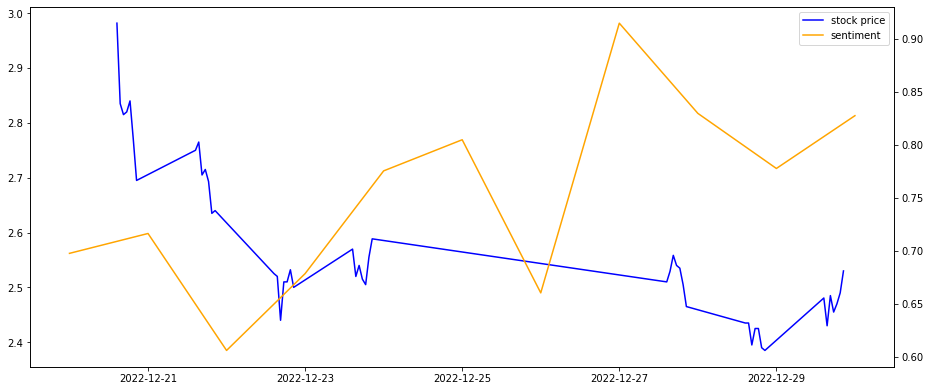

In [188]:
fig = plt.figure(figsize=(12, 5))

ax1 = fig.add_axes([0, 0, 1, 1])
ax2 = fig.add_axes()
# This is the magic that joins the x-axis
ax2 = ax1.twinx()

l1 = ax1.plot(stock['Datetime'],stock['Close'], color='blue', label = "stock price")
l2 = ax2.plot(tweets_df['sentiment'].groupby(pd.to_datetime(tweets_df['Datetime']).dt.floor('d')).mean(), color='orange', label = 'sentiment')

leg = l1 + l2
labs = [l.get_label() for l in leg]
ax1.legend(leg, labs, loc=0)
plt.show()